In [10]:
import jax

jax.config.update("jax_platform_name", "cpu")

from pathlib import Path
from time import time
import matplotlib.pyplot as plt
import numpy as np
import equinox as eqx
from optax.tree_utils import tree_scale
import jax.numpy as jnp

from jaxmat.loader import ImposedLoading, global_solve
from jaxmat.tensors import SymmetricTensor2
import jaxmat.materials as jm


current_path = Path().resolve()

data = np.loadtxt(current_path / "../_data/Treloar_rubber.csv", skiprows=1, delimiter=",")
stress_data = []
load_data = []
for i in range(3):
    load_data.append(data[data[:,2*i]!=np.inf, 2*i])
    stress_data.append(data[data[:,2*i]!=np.inf, 2*i+1])

def plot_results(ax, load, results, **kwargs):
    styles=  ["-", "-.", "--"]
    for lamb, res, style in zip(load, results, styles):
        ax.plot(lamb, res, style, **kwargs)

# @eqx.filter_jit
def solve_hyperelasticity(material, loadings):
    results = []
    for loading in loadings:
        Nbatch = len(loading.eps_vals)
        state = material.init_state(Nbatch)
        F0 = state.F
        dt = 0.0
        F_sol, state_sol, _ = global_solve(F0, state, loading, material, dt)
        # print(F_sol)
        results.append(state_sol.PK1[:,0,0])
    return results


    
lamb_list = jnp.asarray(load_data[0])

# lamb_list = jnp.linspace(1.0, 8.0, 51)
loading_uni = ImposedLoading("finite_strain", FXX=lamb_list, FYY=1/jnp.sqrt(lamb_list), FZZ=1/jnp.sqrt(lamb_list))

lamb_list = jnp.asarray(load_data[1])
# lamb_list = jnp.linspace(1.0, 8.0, 51)
loading_simple = ImposedLoading(
    "finite_strain", FXX=lamb_list, FYY=jnp.ones_like(lamb_list), FZZ=1/lamb_list
)

lamb_list = jnp.asarray(load_data[2])
# lamb_list = jnp.linspace(1.0, 6, 51)
loading_equiax = ImposedLoading("finite_strain", FXX=lamb_list, FYY=lamb_list, FZZ=1/lamb_list**2)
loadings = [loading_uni, loading_simple, loading_equiax]
load_data_res= [l.eps_vals[:,0,0] for l in loadings]
P_ = []
for F_, F, P in zip(load_data_res, load_data, stress_data):
    P_.append(jnp.interp(F_,F,  P))


def eval_loss(results, stress_data):
    return sum([jnp.mean(jnp.square(P1 - P1_data)) for (P1, P1_data) in zip(results, stress_data)])


[-1.18428442 -0.11617041  0.17269028  0.95730718]


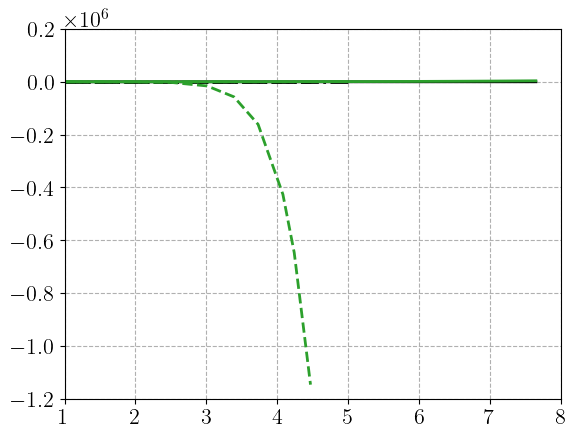

In [2]:

key = jax.random.PRNGKey(1)

# scale_mat = None
scale_mat = jm.Hyperelasticity(
    jm.CompressibleOgden(mu=1.0, alpha=5.0, kappa=1e3))
# scale_mat = jm.Hyperelasticity(
#     jm.CompressibleOgden(mu=jnp.asarray([0.1, 0.2]), alpha=jnp.asarray([2.0, 4.0]), kappa=1e3))



def rescale(scaled_material):
    if scale_mat is None:
        return scaled_material
    else:
        return jax.tree_util.tree_map(lambda p, s: p * s, scaled_material, scale_mat)
    


def compute_loss(scaled_material, loadings):
    material=rescale(scaled_material)
    results = solve_hyperelasticity(material, loadings)
    loss = eval_loss(results, P_)
    return loss, results

loss_grad = jax.value_and_grad(compute_loss, argnums=0, has_aux=True)



N = 4
mus = jax.random.lognormal(key, shape=(N,))
alphas = jax.random.normal(key, shape=(N,))
# alphas = alphas.at[0].set(-alphas[0])
print(alphas)
scaled_mat = jm.Hyperelasticity(
    jm.CompressibleOgden(mu=mus, alpha=alphas, kappa=1))
scaled_mat = jax.tree.map(lambda x: jnp.asarray(x, dtype=jnp.float64), scaled_mat) # force strong type for optax

results = solve_hyperelasticity(rescale(scaled_mat), loadings)
fig, ax = plt.subplots()
plot_results(ax, load_data_res, P_, color="k")
plot_results(ax, load_data_res, results, color="C2")

In [6]:
import optimistix as optx
import lineax as lx



solver = optx.LevenbergMarquardt(rtol=1e-4, atol=1e-4, 
                   linear_solver=lx.AutoLinearSolver(well_posed=False), 
                   verbose=frozenset({"loss", "step_size"}))

@eqx.filter_jit
def loss(scaled_material, loadings):
    material=rescale(scaled_material)
    results = solve_hyperelasticity(material, loadings)
    return [(P1 - P1_data)/jnp.max(P1_data) for (P1, P1_data) in zip(results, P_)], results

new_material = tree_scale(1.0, scaled_mat)
print(rescale(new_material).potential.mu)
print(rescale(new_material).potential.alpha)

[0.30596504 0.89032349 1.18849795 2.6046731 ]
[-5.92142211 -0.58085204  0.8634514   4.7865359 ]


In [7]:
# import optax
# # Define optimizer
# start_learning_rate = 0.01
# optimizer = optax.adam(start_learning_rate)

# opt_state = optimizer.init(scaled_mat)

# new_material = tree_scale(1.0, scaled_mat)

# niter_max = 200
# training_loops = 2
# for training in range(training_loops):
#     for i in range(niter_max+1):
#         (loss, results), dloss = loss_grad(new_material, loadings)
#         updates, opt_state = optimizer.update(dloss, opt_state)
#         new_material = optax.apply_updates(new_material, updates)
#         print(f"Iteration {i} RMS Loss = {jnp.sqrt(loss)}")
#         # new_material = tree_add(new_material, tree_scale(-learning_rate, dloss))
#         # new_material = jax.tree.map(lambda x: jnp.maximum(x, 0), new_material)
#         psi_new = rescale(new_material).potential
#         # print(f"   c1 = {psi_new.c1}, c2 = {psi_new.c2}, Jm = {psi_new.Jm}")
#         # print(f"   c1 = {psi_new.c1}, c2 = {psi_new.c2}")
#         print(f"   mu = {psi_new.mu} alpha = {psi_new.alpha}")
# new_material = rescale(new_material)
# plt.show()

In [8]:
sol = optx.least_squares(loss, solver, new_material, loadings, has_aux=True, throw=False, max_steps=500)

Loss on this step: 156158480601.91428, Step size: 1.0
Loss on this step: 13.405726064418284, Step size: 3.5
Loss on this step: 1.074946937651365, Step size: 3.5
Loss on this step: 0.8009349557236617, Step size: 3.5
Loss on this step: 0.10708923364461266, Step size: 3.5
Loss on this step: 0.5928150492255324, Step size: 0.875
Loss on this step: 0.24663250768630973, Step size: 0.21875
Loss on this step: 0.06702776986802814, Step size: 0.21875
Loss on this step: 0.05687983965109506, Step size: 0.21875
Loss on this step: 0.047118825475906366, Step size: 0.21875
Loss on this step: 0.038219319355312545, Step size: 0.21875
Loss on this step: 0.031213624920917758, Step size: 0.21875
Loss on this step: 0.026782852547548225, Step size: 0.21875
Loss on this step: 0.02436257184129796, Step size: 0.21875
Loss on this step: 0.02298416386687912, Step size: 0.21875
Loss on this step: 0.02209361782139987, Step size: 0.21875
Loss on this step: 0.021458989973802335, Step size: 0.21875
Loss on this step: 0

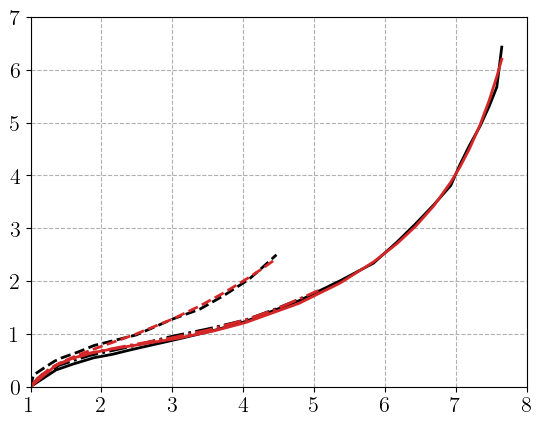

In [9]:
fig, ax = plt.subplots()
results = sol.aux
plot_results(ax, load_data_res,stress_data, color="k")
plot_results(ax, load_data_res,results, color="C3")
plt.show()